# Лабораторная работа №2
Выполнила Титова Анастасия, 520 группа.

## Постановка задачи

Разработать и реализоватьпрограмму для классификации изображений ладоней, которая будет обеспечивать ввод и отображение на экране изображений в формате TIF, сегментацию изображений на основе точечных и пространственных преобразований, генерацию признаковых описаний формы ладоней на изображениях, вычисление меры сходства ладоней, кластеризацию изображений.  

Задача состоит в построении меры сходства изображений на основе выделения и анализа формы ладоней. Нужно разработать и реализовать алгоритм, входом которого является изображение, а выходом – описание признаков формы, попарные расстояния, кластеры изображений.

В качестве признакового описания формы предлагается построить «линию пальцев» – ломаную линию, соединяющую точки на кончиках пальцев (tips) с точками в основаниях пальцев (valleys). Длины 8 звеньев ломаной линии образуют 8-мерный вектор признаков формы ладони. 

В задание входят задачи двух уровней сложности: _Intermediate, Expert_. 

**_Класс Intermediate:_** 
1. Найти на изображении ладони точки в кончиках и основаниях пальцев.  
2. Визуализировать результат для экспертного контроля

**_Класс Expert: _**
3. Найти для каждой ладони 3 наиболее похожих изображения и представить результат в виде таблицы «имя образца – имена ближайших соседей».
4. Определить число людей, чьи ладони представлены в изображениях, и составить списки ладоней для каждого, т.е. провести кластеризацию изображений в виде таблицы «Персона No – имена изображений ладоней».  

**В разработанной программе реализовано решение задачи класса Intermediate**

Входом программы являются изображения в формате TIF.
Выход программы: для класса Intermediate выходом программы является изображение с нанесенной на него «линией пальцев»; для класса Expert, помимо описанного изображения, выводится таблица наиболее схожих изображений и таблица с распределением ладоней по людям.

## Описание данных
Программа работает с цветными изображениями ладоней людей в формате TIF, размером 489×684 с разрешением 72 dpi, полученными с помощью сканера. Предоставленный для обучения набор содержит 99 изображений.

## Описание программной реализации, метода решения и результатов экспериментов



Для реализации решения были использованы следующие бибилиотеки:

In [1]:
import numpy as np
import cv2
import os
import math
from matplotlib import cm
from matplotlib import pyplot as plt
from scipy import ndimage as ndi
from PIL import Image
%matplotlib inline

В программе также реализованы некоторые вспомогательные функции


In [ ]:
def showim(image, cm=None): #Show image
    fig = plt.figure(figsize = (13,13))
    ax = fig.add_subplot(111)
    ax.imshow(image, cmap=cm) 
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

Основной алгоритм реализован в функции extractHandFeature(), которая принимает на вход путь папки с изображениями рук, на которые необходимо нанести ломаную, длины 8 звеньев которой образуют 8-мерный вектор признаков формы ладони. Функция последовательно обрабатывает каждый файл с расширением TIF в папке, другие файлы игнорируются.
Ниже последовательно описываются этапы алгоритма, фрагменты кода каждого этапа приведены после описания.

#### 1. Создание маски для выделения руки на изображении

На предоставленом наборе изображений отсканированная ладонь явно выделяется на фоне, фон практически чёрный, следовательно для нашей цели подойдет простая пороговая бинаризация. По гистаграмме яркости для различных изображений из набора видно, что необходимый порог лежит в границах 40-60, эмпирически выбран порог 40, он позволяет снизить количество артефактов, но в случае близко расположенных пальцев, теряется четкая граница между ними. К полученной маске применяем фильтр размытия, применяем пороговую обработку к "размытой" картинке. Далее применяем эрозию для разделения слившихся деталей ладони. Применяем distanse transform к нашей области, чтобы пороговой обработкой максимально отделить области, не относящиеся к ладони. На получившейся маске выделяем связные компоненты и удаляем те из них, чей размер не превосходит эмпирически подобранного порога (3060). К полученной маске применяем дилатацию, чтобы далее вычитанием получить маску "лишних" областей и, наконец, получить маску для ладони.

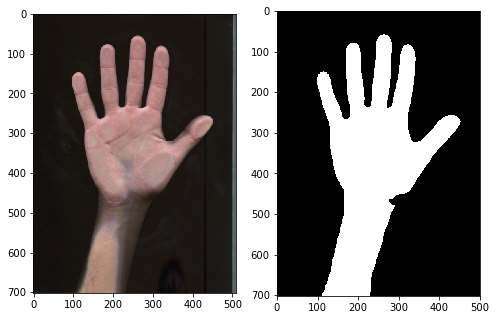

In [2]:
fig=plt.figure(figsize=(8, 8))
img = cv2.cvtColor(cv2.imread("ex1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.imread("ex15.jpg")
fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow(img2)
plt.show()

In [ ]:
#загружаем изображение
img = cv2.imread(os.path.join(path, filename))
#переводим в grayscale
img2=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#пороговая обработка
ret,thresh1 = cv2.threshold(img2,40,255,cv2.THRESH_BINARY)
#обрезаем полосу засветки
thresh1=thresh1[:,:500]
#размываем изображение, чтобы улучшить нашу маску
blur = cv2.blur(thresh1,(5,5))
#повторно бинаризуем
ret,thresh1 = cv2.threshold(blur,200,255,cv2.THRESH_BINARY)
kernel = np.ones((4,4),np.uint8)        
kernelCL = np.ones((11,11),np.uint8)
#уменьшаем область, чтобы максимально разъединить "слипшиеся" части руки
final = cv2.erode(thresh1,kernel,iterations = 1)
#применяем distance transform и бинаризуем, тем самым пытаемся убрать или отделить от ладони лишние фрагменты
dist_transform = cv2.distanceTransform(final,cv2.DIST_L2,5)
ret,thresh2 = cv2.threshold(dist_transform,10,255,cv2.THRESH_BINARY)
thresh2 = np.uint8(thresh2)
#выделяем связные компоненты, удаляем лишние области, применяя пороговую обработку по размеру
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh2, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1
min_size = 3060
answer = np.zeros((output.shape))
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        answer[output == i + 1] = 255
answer = np.uint8(answer)
#применяет дилатацию к полученной маске ладони 
mask = cv2.dilate(answer, kernelCL,iterations = 5)
#вычитаем её из первой маски, получаем маску на "лишние" области
result = cv2.subtract(thresh1,mask)
#вычитанием "лишнего" получаем итоговую маску ладони
result = cv2.subtract(thresh1,result)

#### 2. Выделение контуров и построение выпуклой оболочки области

Далее по полученной маске получаем контуры руки с помощью функции findContours с режимом RETR_TREE(выделяет все контуры и восстанавливает полную иерархию) и методом аппроксимации CHAIN_APPROX_SIMPLE (сжимает горизонтальные, вертикальные и диагональные сегменты и оставляет только из конечные точки).
Далее сортируем наши контуры по площади, которую они ограничивают, и оставляем самый большой из них - это и есть контур ладони.

По полученному контуру, с помощью функции convexHull строим выпуклую оболочку области. Для поиска выпуклой оболочки используется алгоритм Джека Склянски [Jack Sklansky Finding the convex hull of a simple polygon(1982)](https://dl.acm.org/citation.cfm?id=2306049).


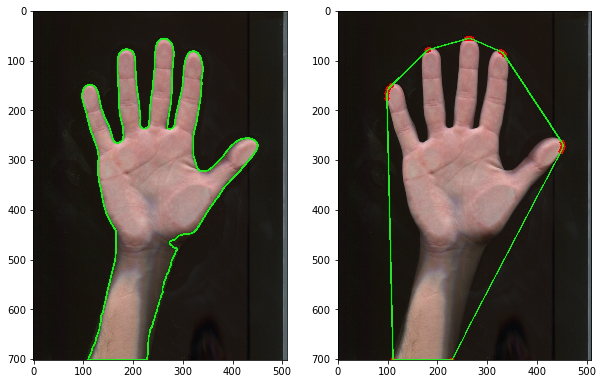

In [3]:
fig=plt.figure(figsize=(10, 10))
img = cv2.cvtColor(cv2.imread("ex16.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("ex17.jpg"), cv2.COLOR_BGR2RGB)
fig.add_subplot(1,2,1)
plt.imshow(img)
fig.add_subplot(1,2,2)
plt.imshow(img2)
plt.show()

In [ ]:
#выделяем контуры, оставляем самый большой -- это контур нашей ладони
im2, contours, hierarchy = cv2.findContours(result,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:1]

#находим выпуклую оболочку для нашего контура
img = cv2.imread(os.path.join(path, filename))
for c in cnts:
    hull = cv2.convexHull(c,returnPoints=True) #сами точки, которые образуют выпуклую оболочку
    hull2 = cv2.convexHull(c,returnPoints=False) #индексы точек

Как видно на картинках выше, полученная выпуклая оболочка имеет множество точек, расположенных близко друг к другу. На некоторых картинках из выборки, выпуклая оболчка также строится по большому числу точек на ребре ладони. Для этого мы проведём кластеризацию точек, образующих выпуклую оболочку, и из каждой группы выберем центральную точку, которая и попадёт в итоговую выпуклую оболочку нашей области.

#### 3. Выделение кончиков пальцев

Создаем массив маркировки точек выпуклой оболочки. Так как точки контура и точки выпуклой оболочки вносятся в массив последовательно, для каждой точки достаточно определить расстояние между рассматриваемой точкой и следующей точкой из массива (для последнего элемента смотрим расстояние до первого элемента массива), если оно меньше 17 (порог подобран эмпирически), следующей точке присваиваем ту же метку, что и текущей, иначе увеличиваем значение метки на единицу и маркируем следующую точку. Если расстояние между последним элементом массива и первым оказалось меньше порогового значения, объединяем два кластера, присваивая всем элементам с меткой последнего элемента, метку 0.
Для каждого кластера ищем центральную точку. По порядку рассматриваем все метки и смотрим соответствующие точки, находим среднее для точек (наш центр) и ищем элемент, наиболее близкий к ней. Составляем новые массивы для выпуклой оболочки, содержащие только наиболее близкие к центру скопления точек элементы. 
На изображении представлена получившаяся выпуклая оболочка.

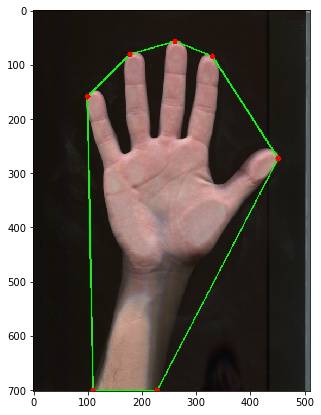

In [4]:
fig=plt.figure(figsize=(7, 7))
img = cv2.cvtColor(cv2.imread("ex20.jpg"), cv2.COLOR_BGR2RGB)
fig.add_subplot(1,1,1)
plt.imshow(img)
plt.show()

In [ ]:
#массив меток для точек выпуклой оболочки
labels =np.zeros(len(hull))
num = 0
for i, point in enumerate(hull):
    if i != len(hull) - 1:
        next_i = i + 1
    else:
        next_i = 0
    nex = hull[next_i]
    y1 = nex.item(1) - point.item(1)
    x1 = nex.item(0) - point.item(0)
    #если расстояние меньше порога, следующей точке массива присваивается текущая метка
    if (math.sqrt(x1**2 + y1**2)<17):
        #в случае, если рассматриваемый элемент - последний, объединяем текущую метку и нулевую
        if next_i==0:
            m = labels[i]
            ind = find_indices(labels, lambda x: x == m)
            for item in ind:
                labels[item]=0
        else:
            labels[next_i] = num 
    #если расстояние больше, вводим новый кластер, маркируем следующую точку его номером
    else:
        num=num+1
        labels[next_i] = num
        
new_hull=np.zeros((len(np.unique(labels)),2))
new_ind_hull= np.zeros((len(np.unique(labels)),1))
#далее ищем центральную точку каждого кластера
uni = np.unique(labels)
uni = np.uint64(uni)
fl=0
#для каждой метки смотрим все точки, помеченные ей,
#находим среднее для них и ищем точку, наиболее близкую к центру
for value in uni:
    ind = find_indices(labels, lambda x: x == value)
    area = hull[ind]
    cent = np.mean(area,0)
    for j, i in enumerate(ind):
        curr_dist = math.sqrt((hull[i].item(0)-cent.item(0))**2 + (hull[i].item(1)-cent.item(1))**2)
        if j == 0:
            dist= curr_dist
            ind_m = i
        else:
            if curr_dist < dist:
                ind_m = i
                dist = curr_dist
    #составляем новые массивы для выпуклой оболочки, содержащие "центры"
    new_hull[fl]=hull[ind_m]
    new_ind_hull[fl]=hull2[ind_m]
    fl=fl+1
new_hull = np.uint64(new_hull)
new_ind_hull = np.uint64(new_ind_hull)

#### 4. Выделение точек в основаниях пальцев

Точки у оснований пальцев (valleys) удобно искать как дефекты выпуклости контура (convexityDefects), однако такие точки будут находиться не только в основаниях пальцев, но и у основания ладони, а в случае изображениё, где контур области выделяется неровно, такие точки будут находиться в различных частях ладони и запястья. 
Однако точки у оснований пальце в примечательны тем, что отклонение от выпуклого контура в них максимально. Отсортируем их по этому показателю и получим массив координат вершин нашей ломаной, т.к. функция convexityDefects возвращает координаты начала, конца, наиболее отдоленной точки и максимальное отклонение от выпуклого контура для каждой области, которая находится между контуром области и её выпуклой оболочкой.
Оставим 4 наиболее отдаленных от контура точки, запишем информацию о звеньях ломаной в наш вектор признаков и сохраним размеченное изображение в папку 'result' под тем именем исходного.

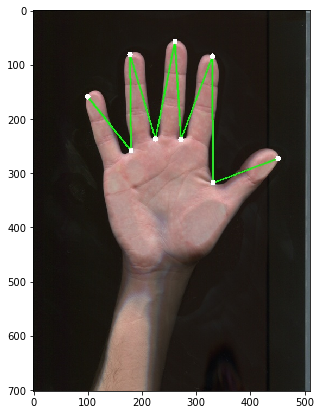

In [5]:
fig=plt.figure(figsize=(7, 7))
img = cv2.cvtColor(cv2.imread("ex21.jpg"), cv2.COLOR_BGR2RGB)
fig.add_subplot(1,1,1)
plt.imshow(img)
plt.show()

In [ ]:
feature = np.zeros(8)
m=0
#находим дефекты выпуклости
defects = cv2.convexityDefects(c,new_ind_hull)
#сортируем их по отклонению контура от выпуклой оболочки и оставляем 4 наиболее отдаленные точки
dfcts = sorted(defects, key = lambda x: x[0][3], reverse = True)[:4]
#записываем вектор признаков и сохраняем размеченное изображение в папку "result" под именем исходного изображения
for i in range(4):
    s,e,f,d = dfcts[i][0]
    start = tuple(c[s][0])
    end = tuple(c[e][0])
    far = tuple(c[f][0]) 
    #записываем длины звеньев в вектор признаков
    y1 = start[1] - far[1]
    x1 = start[0] - far[0]
    y2 = end[1] - far[1]
    x2 = end[0] - far[0]
    feature[m]=math.sqrt(x1**2 + y1**2) 
    feature[m+1] = math.sqrt(x2**2 + y2**2)
    m = m+2
    #наносим звенья ломаной на изображение
    cv2.line(img,start,far,[0,255,0],2)
    cv2.line(img,far,end,[0,255,0],2)
    cv2.circle(img,start,5,[255,255,255],-1)
    cv2.circle(img,end,5,[255,255,255],-1)
    cv2.circle(img,far,5,[255,255,255],-1)
cv2.imwrite(os.path.join('./result', filename),img)

## Выводы

В итоговом виде алгоритм работает таким образом, что качество маски не играет большой роли, можно было бы опустить часть преобразований, например удаление лишних областей, так как позже мы бы отбросили их при сортировке контура.